<a href="https://colab.research.google.com/github/SurakshaRV/Chatbot-for-skin-disease-diagnosis/blob/main/skin_disease_classification_with_MobileNets(original_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# The paths for the training and validation images
train_path = '/content/drive/MyDrive/base_dir2/train_dir2'
valid_path = '/content/drive/MyDrive/base_dir2/test_dir2/val_dir2'
test_path= '/content/drive/MyDrive/base_dir2/test_dir2/testing_dir2'

#number of images in the training set
num_train_samples = 6009
#number of images in the evaluation set
num_val_samples = 2003
#number of images in the test set
num_test_samples = 2004
#dimensions of the image that will be inputed into the network (224x224)
image_size = 224

train_batch_size = 20
val_batch_size = 20
'''#declare grid search parameters
batch_size=train_batch_size = val_batch_size= [10, 20, 40, 60, 80, 100]
epochs = [20, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)'''

# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [5]:
# Set up generators
train_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, #pointing to the path where the data is stored
    target_size=(image_size, image_size), #the target size of the image output
    batch_size=train_batch_size) #size of the batches

valid_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size)

test_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False)

Found 6066 images belonging to 7 classes.
Found 2028 images belonging to 7 classes.
Found 2037 images belonging to 7 classes.


In [6]:
#Create a MobileNet model
mobile = keras.applications.mobilenet.MobileNet()

# Modify the model
# Choose the 6th layer from the last
x = mobile.layers[-6].output

# Add a dropout and dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# Create a new model with the new outputs
model = Model(inputs=mobile.input, outputs=predictions)

# Prevent everything except the last 23 layers from being trained
for layer in model.layers[:-23]:
  layer.trainable = False

17227776/17225924 [==============================] - 0s 0us/step


In [7]:
# Define Top2 and Top3 Accuracy
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

# Add weights to make the model more sensitive to melanoma
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 1.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

In [8]:
filepath = "/content/drive/MyDrive/skin_lesion_model(orig-dataset).h5"

# Compile the model
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=20,
                              verbose=1,
                              callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
301/301 [==============================] - ETA: 0s - loss: 1.0315 - categorical_accuracy: 0.6938 - top_2_accuracy: 0.8265 - top_3_accuracy: 0.9104
Epoch 00001: val_top_3_accuracy improved from -inf to 0.87079, saving model to /content/drive/MyDrive/skin_lesion_model(orig-dataset).h5
301/301 [==============================] - 1755s 6s/step - loss: 1.0315 - categorical_accuracy: 0.6938 - top_2_accuracy: 0.8265 - top_3_accuracy: 0.9104 - val_loss: 2.2768 - val_categorical_accuracy: 0.5673 - val_top_2_accuracy: 0.7921 - val_top_3_accuracy: 0.8708
Epoch 2/20
301/301 [==============================] - ETA: 0s - loss: 0.7046 - categorical_accuracy: 0.7542 - top_2_accuracy: 0.8869 - top_3_accuracy: 0.9514
Epoch 00002: val_top_3_accuracy improved from 0.87079 to 0.93960, saving model to /content/drive/MyDrive/skin_lesion_model(orig-dataset).h5
301/301 [==============================] - 96s 317ms/step - loss: 

In [9]:
# Evaluation of the best epoch
model.load_weights('/content/drive/MyDrive/skin_lesion_model(orig-dataset).h5')

test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc = model.evaluate_generator(test_batches, steps=val_steps)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
test_loss: 0.8639388084411621
test_cat_acc: 0.801980197429657
test_top_2_acc: 0.9326732754707336
test_top_3_acc: 0.9742574095726013


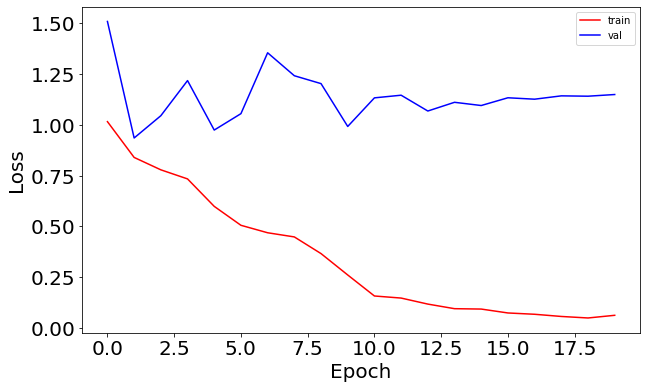

In [10]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

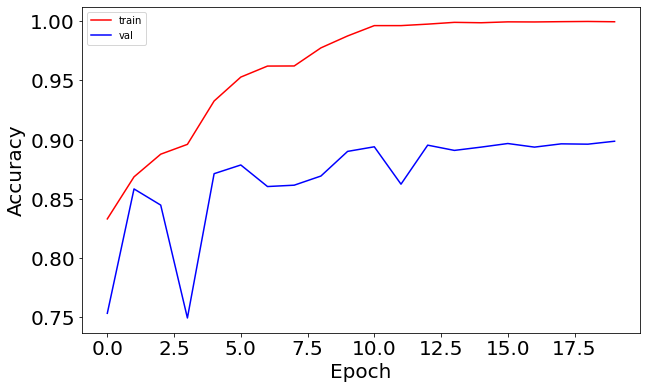

In [11]:
# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['categorical_accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_categorical_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [12]:
# Create a confusion matrix of the test images
test_labels = test_batches.classes

# Make predictions
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
101/101 [==============================] - 21s 211ms/step


In [16]:
print(len(test_labels), len(predictions))

2037 2020


In [13]:
# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  28    7   18    1   10    1    0]
 [   3   69    6    0    5   19    1]
 [   2    7  145    0   26   40    0]
 [   3    1    4    5    4    6    0]
 [   5    1   29    0  110   76    1]
 [   0   12   47    0   57 1249    2]
 [   0    3    0    0    1    2   14]]
True Positives: 69
True Negatives: 28
False Positives: 7
False Negatives: 3
--------------------------------------------------
Accuracy: 0.91
Mis-Classification: 0.09
Sensitivity: 0.96
Specificity: 0.8
Precision: 0.8
f_1 Score: 0.87


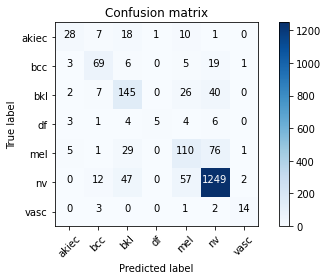

In [17]:
#plot the matrix
cm = confusion_matrix(test_labels[:-17], predictions.argmax(axis=1))
# matrix labels
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import pandas as pd
# calculate roc curve
test_labels2=test_labels[:-17]
# structures
fpr = dict()
tpr = dict()
roc_auc = dict()
# calculate dummies once
y_test_dummies = pd.get_dummies(test_labels2, drop_first=False).values
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [32]:
classes=["akiec","bcc","bkl","df","mel","nv","vasc"]

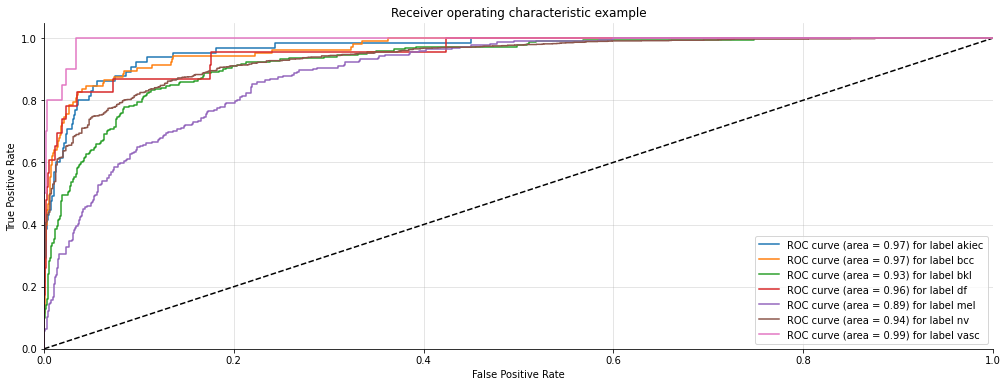

In [36]:
import seaborn as sns
# roc for each class
fig, ax = plt.subplots(figsize=(17,6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
for i in range(7):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i],classes[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()